In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from functools import partial

import xgboost as xgb
from sklearn import preprocessing
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# custom modules
from preproc import load_data,scale_data
#from calibration1 import calibrate_probs,optimize_calibration
from calibration2 import calibrate_probs,optimize_calibration

***
## loading data

In [2]:
train,test,input_cols = load_data()

display(train)
display(test)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
model_params = {
    'booster': 'gbtree',
    'grow_policy': 'depthwise',
    'objective': 'binary:logistic',
    'verbosity': 0,
    'seed': 2112,
    'eta': 0.005,
    'alpha': 1.6994352608068032e-10,
    'colsample_bytree': 0.65,
    'gamma': 0.0002696679879623113,
    'lambda': 1.0733197133336225e-08,
    'max_delta_step': 0.5654183860930762,
    'max_depth': 6,
    'min_child_weight': 6,
    'num_iterations': 3478,
    'scale_pos_weight': 4.712962962962963,
    'subsample': 0.6,
    'tree_method': 'hist'
}

In [7]:
VERBOSE = True

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)
        
        _model_params = dict(model_params)
        num_iterations = _model_params.pop('num_iterations')

        train_dset = xgb.DMatrix(
            data=train_df.loc[:,input_cols],
            label=train_df.loc[:,"Class"].values,
        )
        model = xgb.train(
            params=_model_params,
            dtrain=train_dset,
            num_boost_round=num_iterations,
        )
        
        y_pred = model.predict(xgb.DMatrix(valid_df.loc[:,input_cols]))
        valid_loss = balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred
        
        models.append(model)
        metrics.append(valid_loss)
        
    oof_dfs.append(oof)

REPEAT NUMBER: 1/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 2/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 3/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 4/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 5/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 6/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUM

***
## OOF analysis and calibration

In [8]:
oof_scores = oof_dfs[0].copy()
oof_scores.rename({"pred_proba":"pred_proba0"}, axis=1, inplace=True)

for i in range(1, len(oof_dfs)):
    _df = oof_dfs[i].copy()
    _df.rename({"pred_proba":f"pred_proba{i}"}, axis=1, inplace=True)
    oof_scores = oof_scores.merge(_df, on=["Id","Class"])
    
oof_scores["avg_proba"] = oof_scores.iloc[:,2:].mean(axis=1)
oof_scores

,Id,Class,pred_proba0,pred_proba1,pred_proba2,pred_proba3,pred_proba4,pred_proba5,pred_proba6,pred_proba7,pred_proba8,pred_proba9,avg_proba
0,000ff2bfdfe9,1,0.882855,0.944226,0.930745,0.876267,0.853948,0.897468,0.930342,0.914988,0.937931,0.905798,0.907457
1,007255e47698,0,0.006191,0.006802,0.007802,0.007100,0.006074,0.005800,0.010838,0.004709,0.010086,0.007986,0.007339
2,013f2bd269f5,0,0.136154,0.174432,0.101505,0.235133,0.100602,0.124758,0.161465,0.125364,0.171337,0.090272,0.142102
3,043ac50845d5,0,0.199512,0.059220,0.048206,0.133764,0.078141,0.097076,0.145569,0.077370,0.089199,0.076769,0.100483
4,044fb8a146ec,1,0.433669,0.388173,0.464819,0.384142,0.409040,0.373954,0.439095,0.514361,0.297115,0.377390,0.408176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0,0.055145,0.028743,0.076101,0.022808,0.021047,0.027546,0.062427,0.024400,0.058264,0.022093,0.039858
613,fd895603f071,0,0.091102,0.057767,0.114270,0.056228,0.104160,0.103693,0.064397,0.096247,0.065478,0.082898,0.083624
614,fd8ef6377f76,0,0.019172,0.033383,0.010232,0.021249,0.023192,0.038948,0.024416,0.011832,0.032002,0.028262,0.024269
615,fe1942975e40,0,0.039044,0.032215,0.024413,0.057335,0.033436,0.024266,0.032411,0.025462,0.047851,0.038268,0.035470


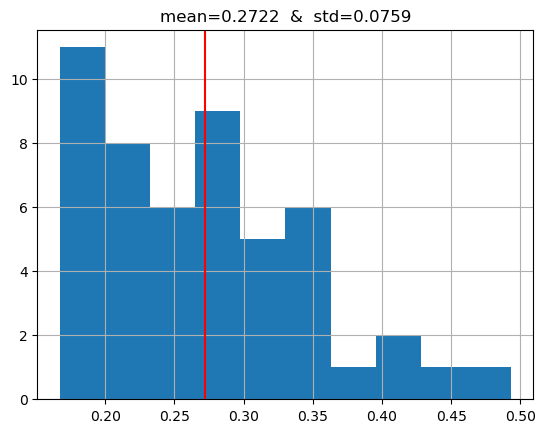

In [9]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

In [10]:
calib_params = optimize_calibration(oof_dfs)

best_value: 0.22564184381208174
best_params: {'alpha': 3.435534900122834, 'beta': 5.3466804742402925, 'gamma': 0.9974294565443753}


####################################################################################################
CV repeat nbr: 1 - metric: 0.2685


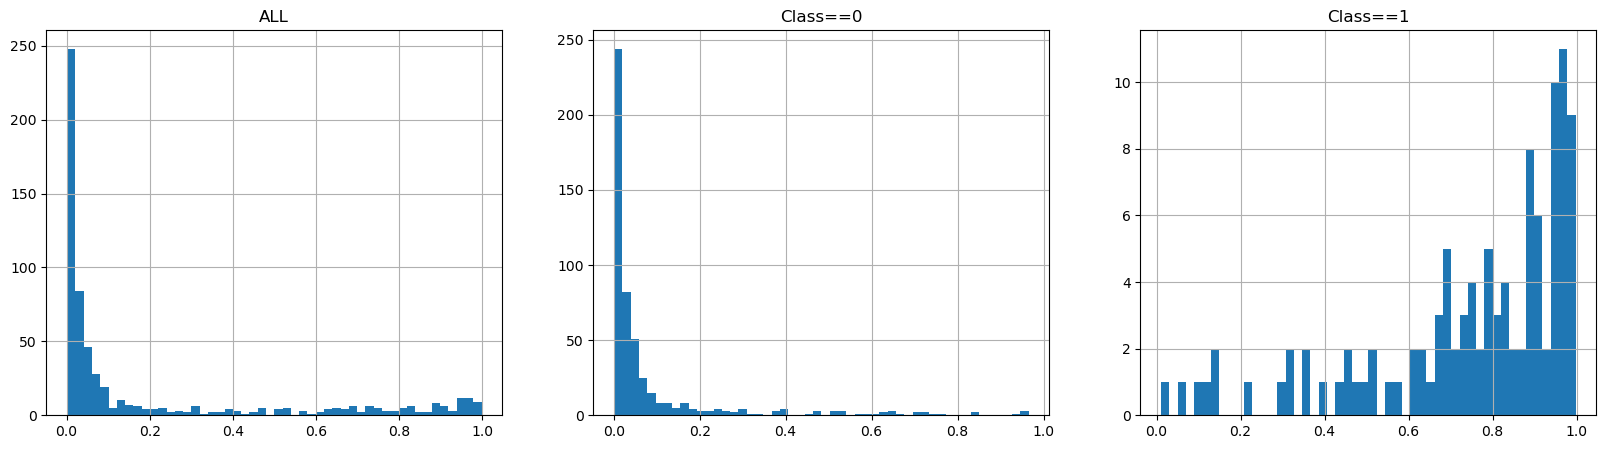

CV repeat nbr: 1 - metric: 0.2213


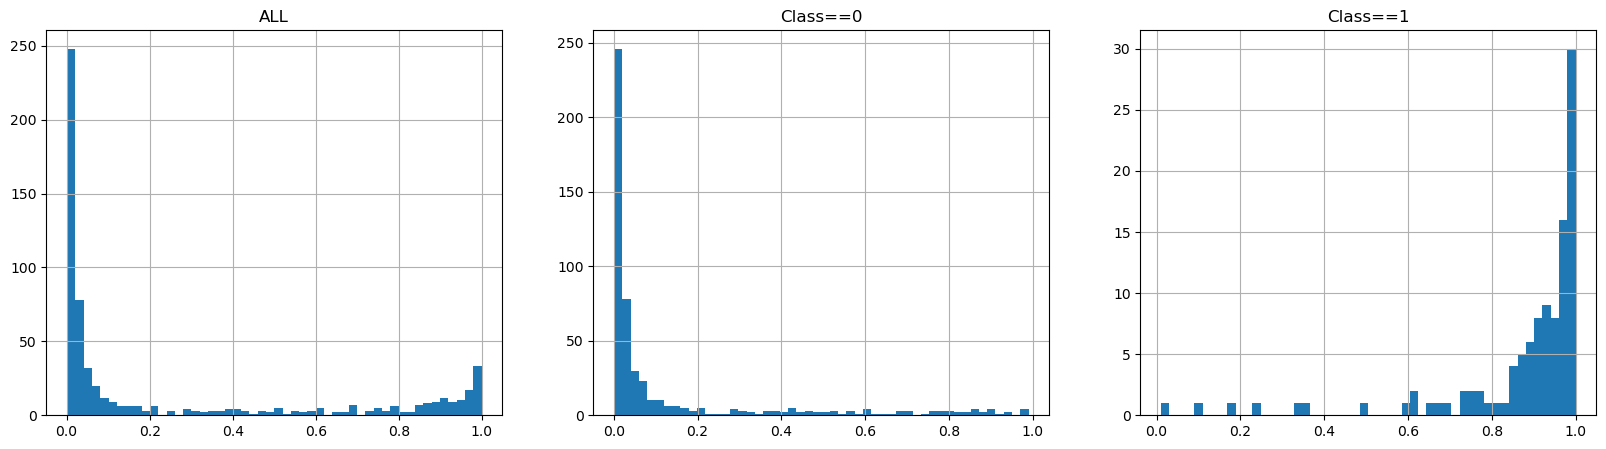

####################################################################################################
CV repeat nbr: 2 - metric: 0.2794


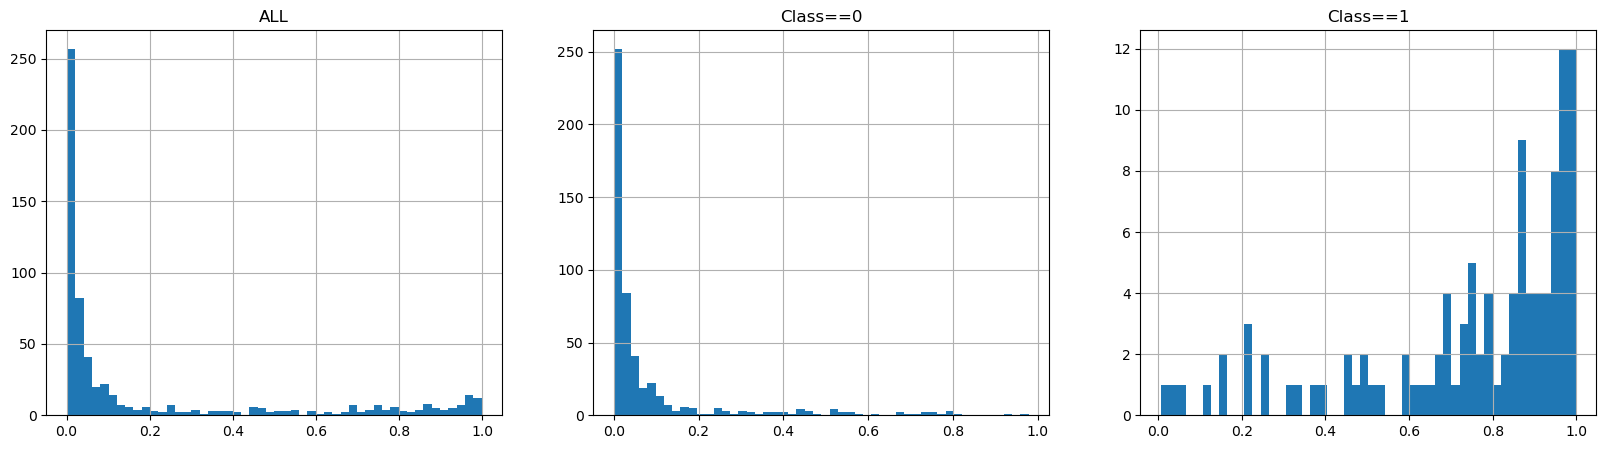

CV repeat nbr: 2 - metric: 0.2336


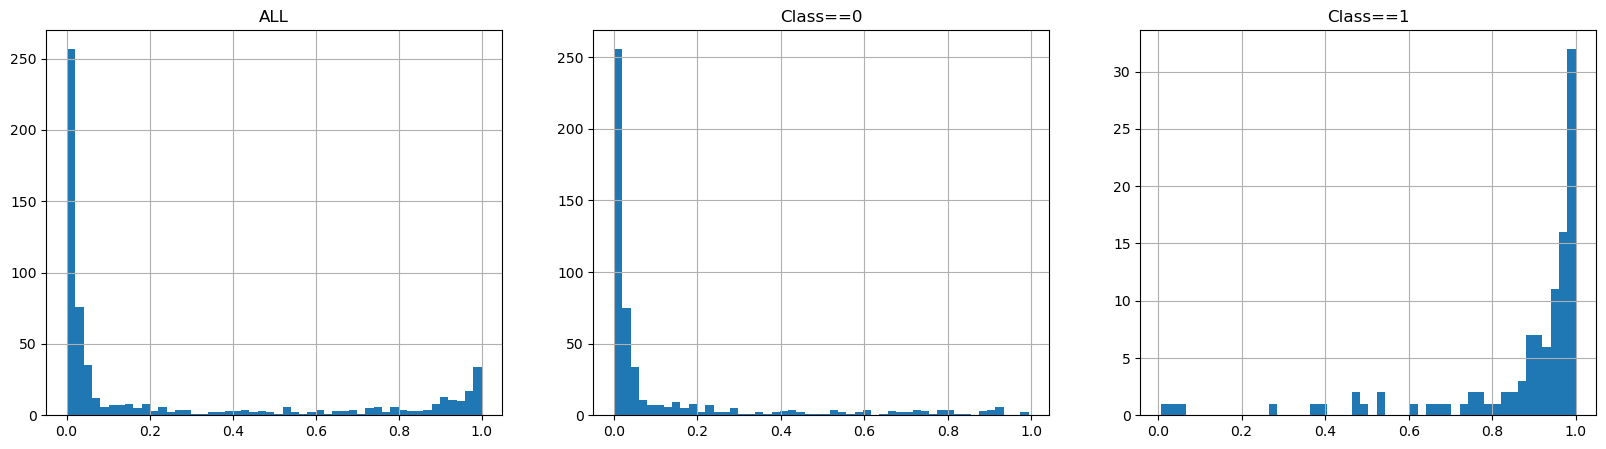

####################################################################################################
CV repeat nbr: 3 - metric: 0.2719


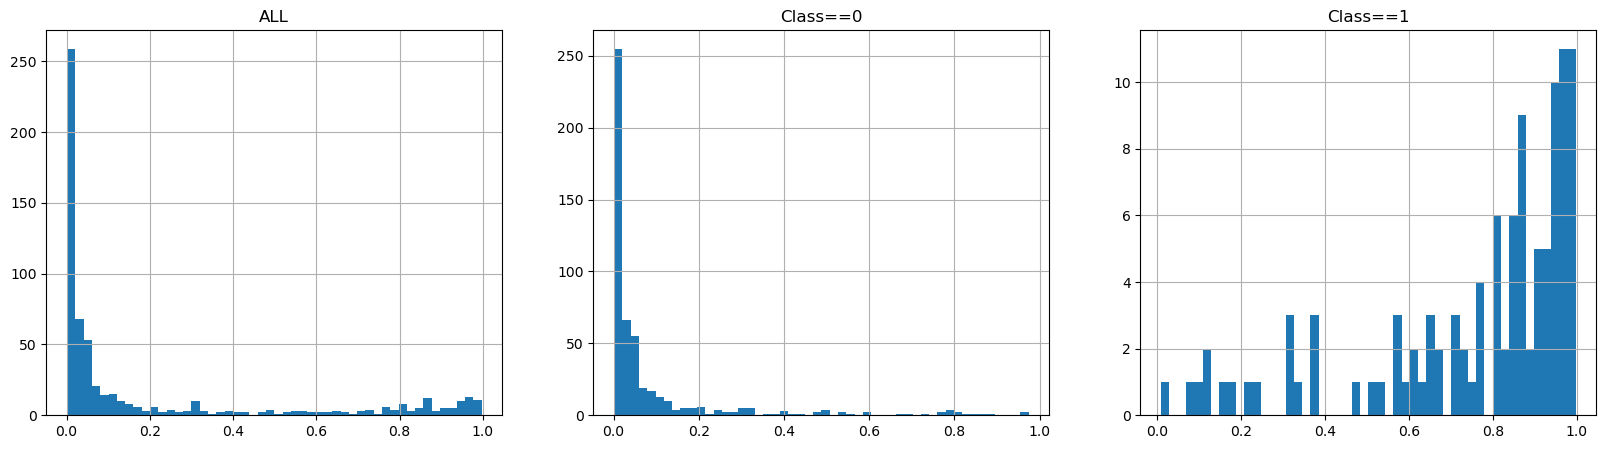

CV repeat nbr: 3 - metric: 0.2264


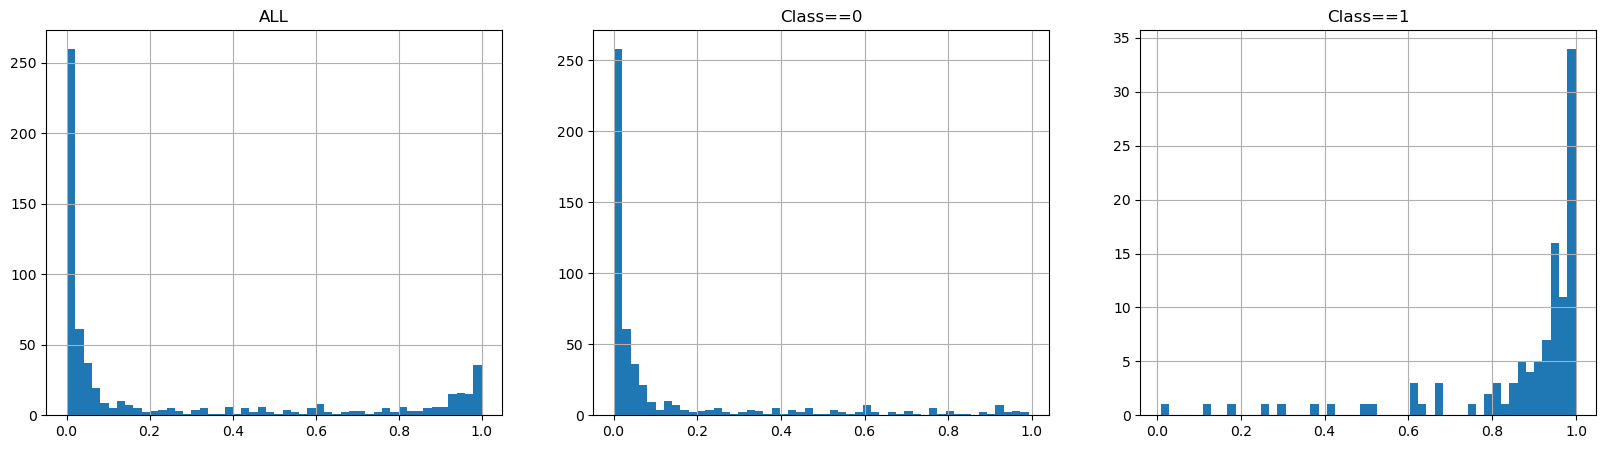

####################################################################################################
CV repeat nbr: 4 - metric: 0.2679


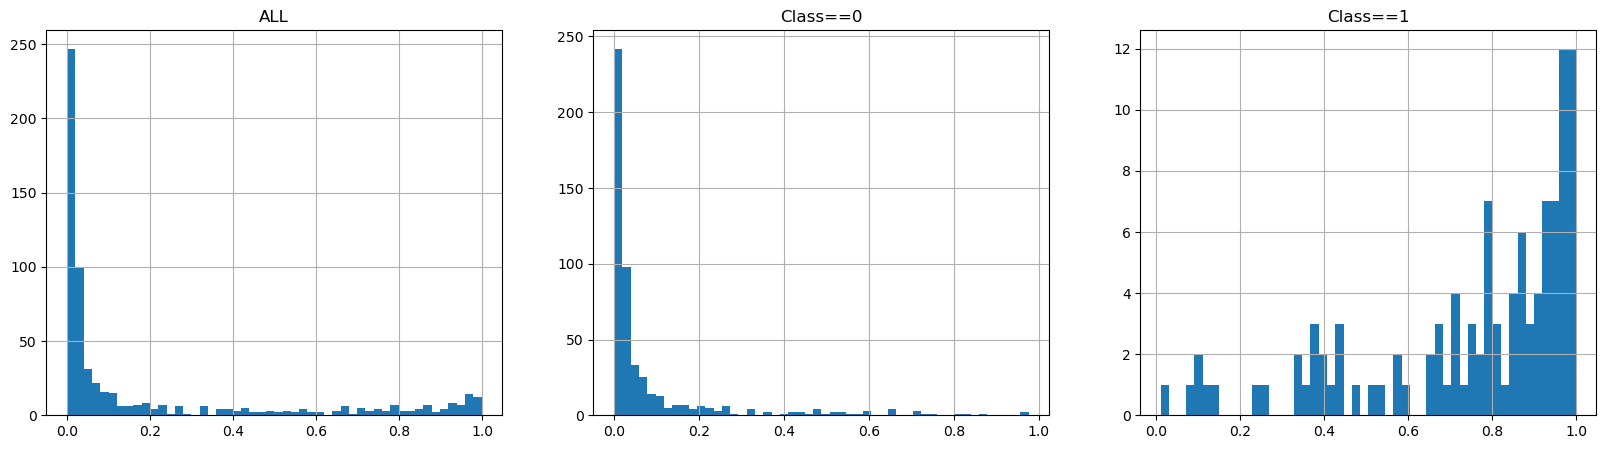

CV repeat nbr: 4 - metric: 0.2197


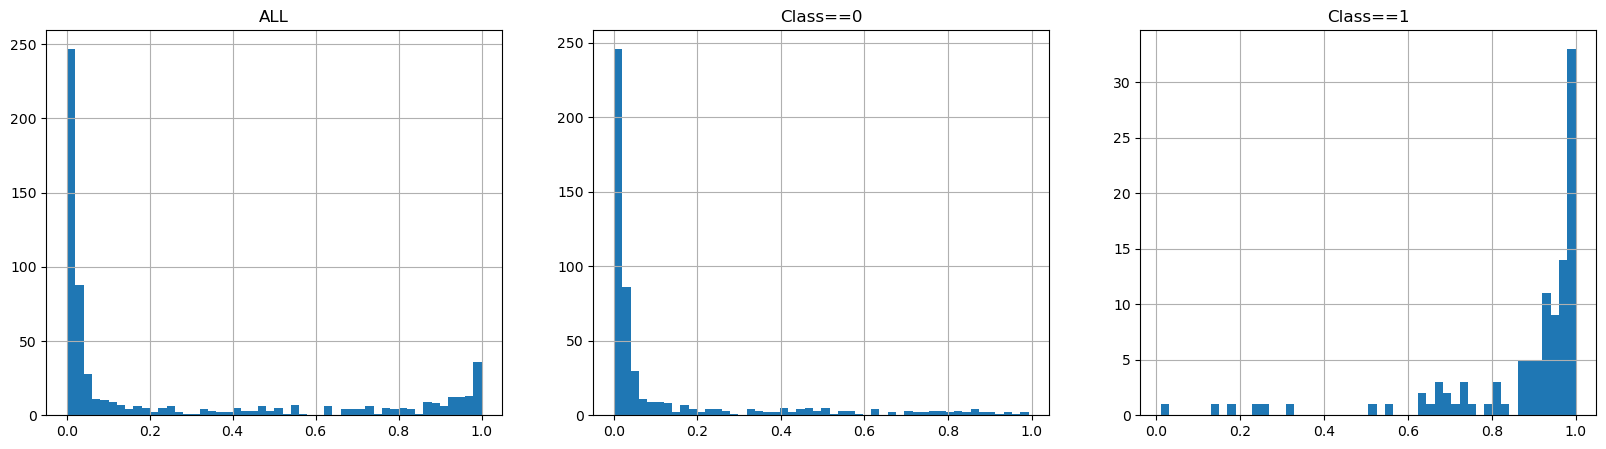

####################################################################################################
CV repeat nbr: 5 - metric: 0.2800


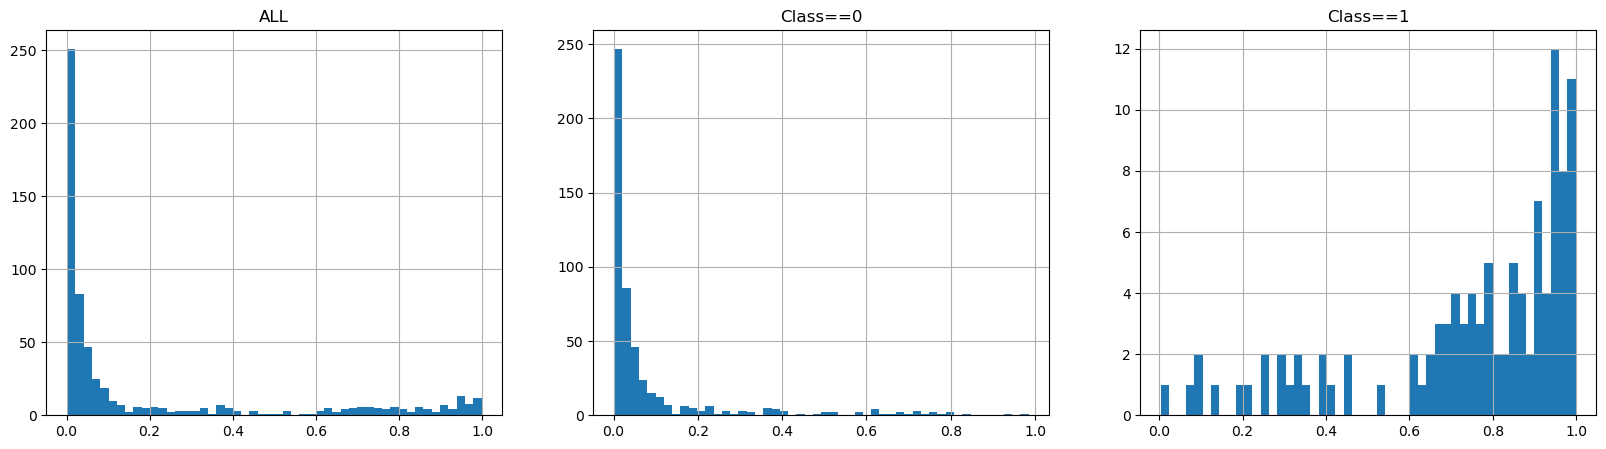

CV repeat nbr: 5 - metric: 0.2297


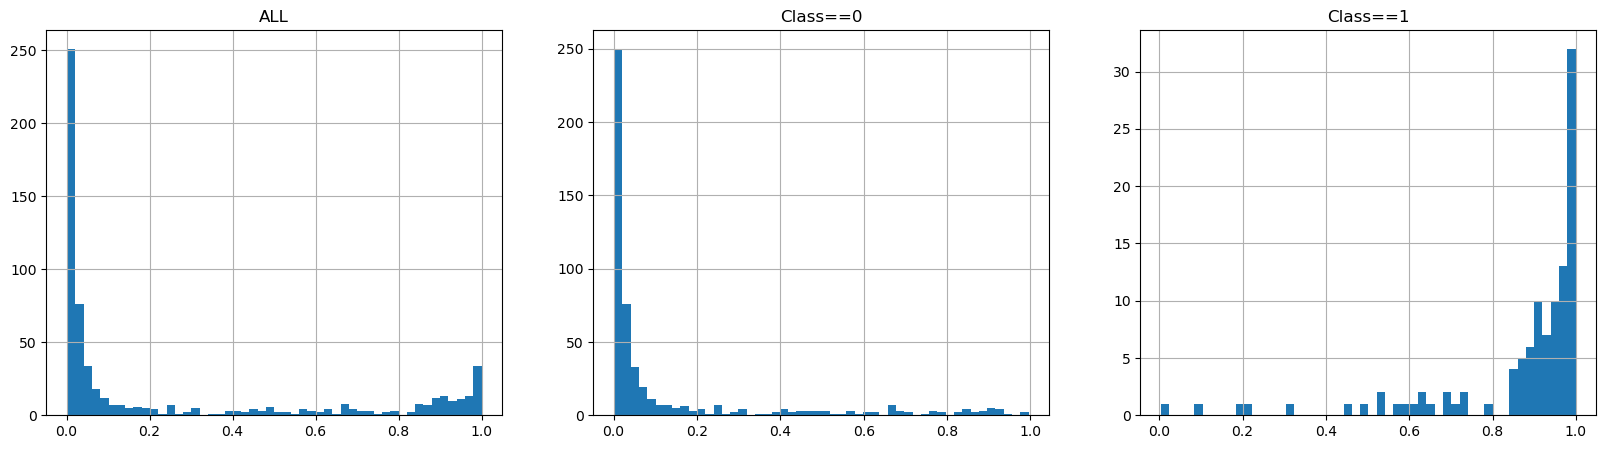

####################################################################################################
CV repeat nbr: 6 - metric: 0.2678


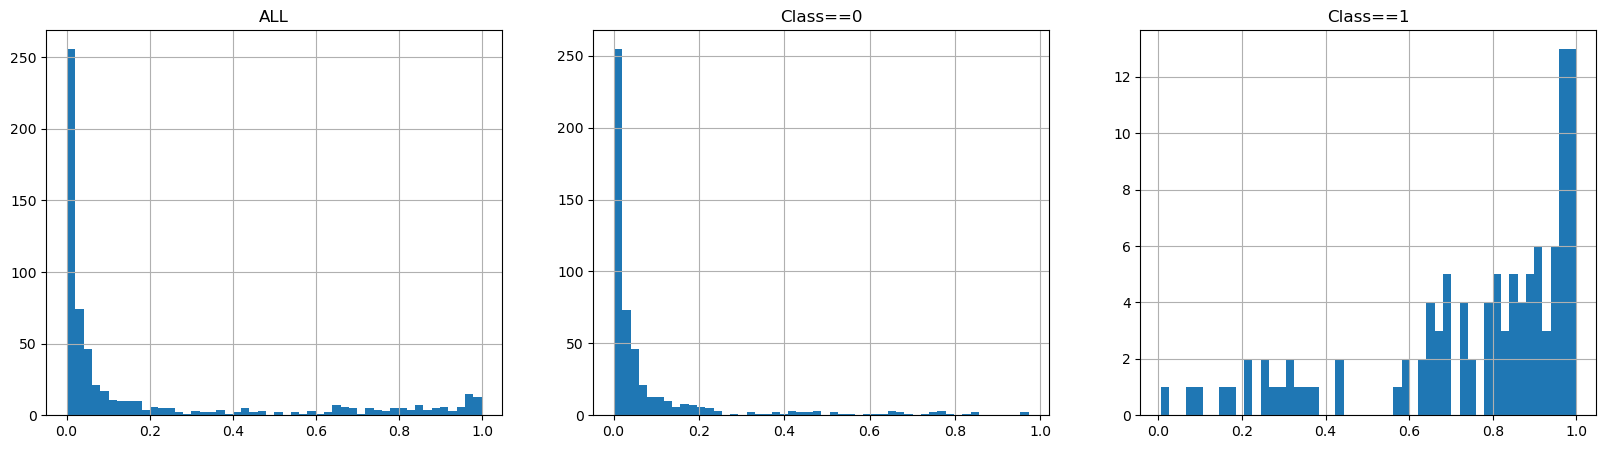

CV repeat nbr: 6 - metric: 0.2213


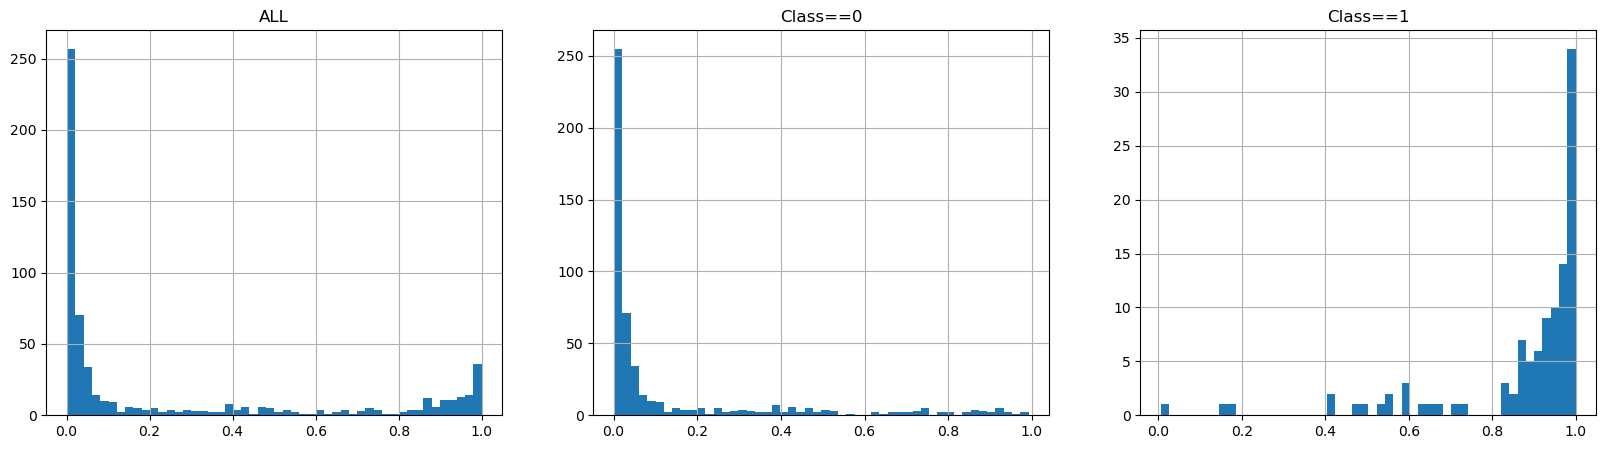

####################################################################################################
CV repeat nbr: 7 - metric: 0.2664


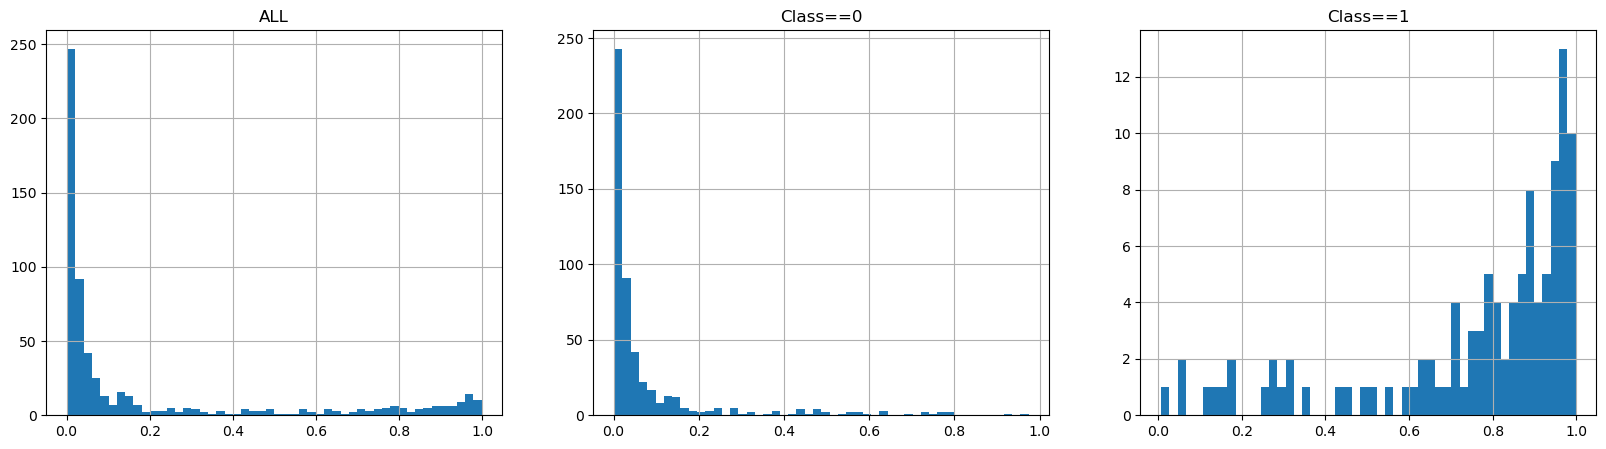

CV repeat nbr: 7 - metric: 0.2202


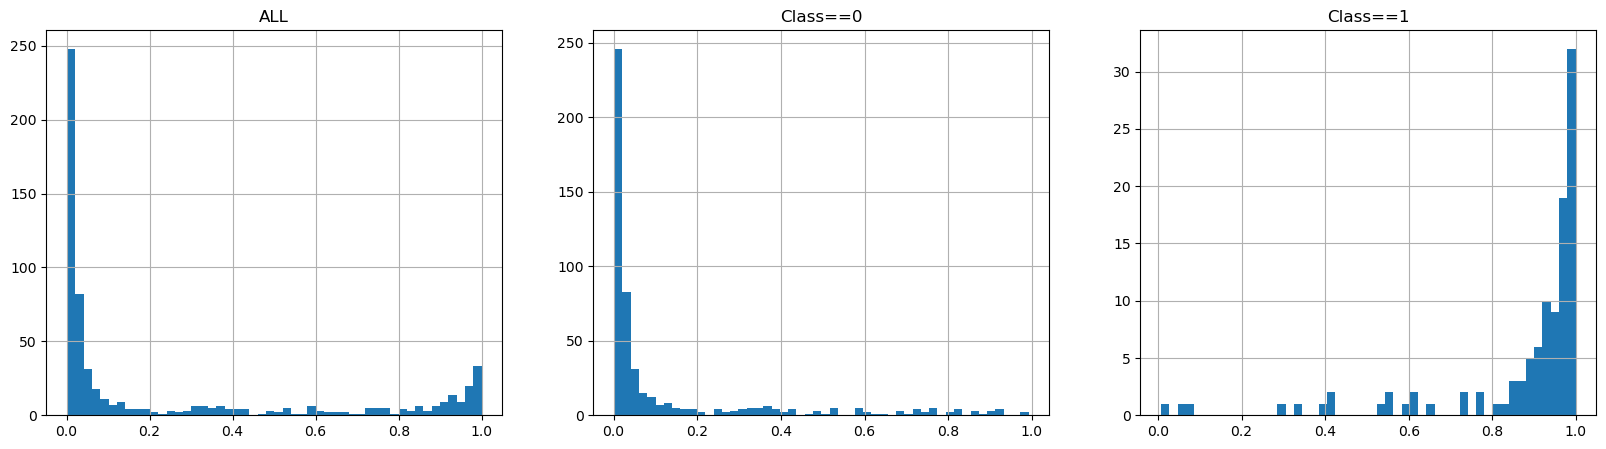

####################################################################################################
CV repeat nbr: 8 - metric: 0.2645


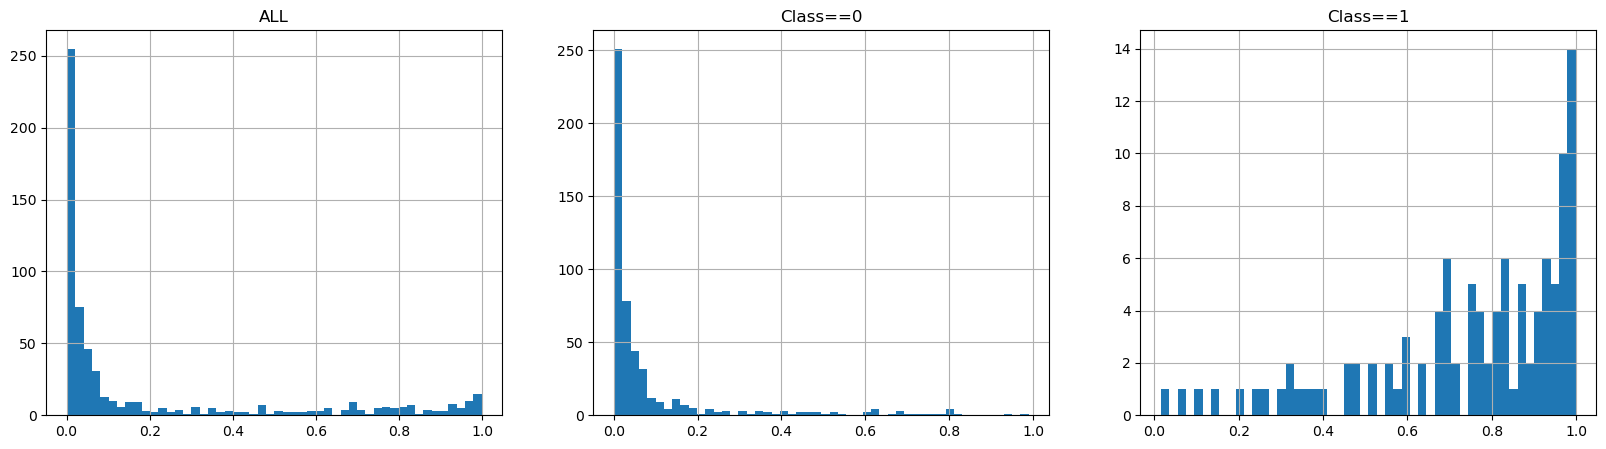

CV repeat nbr: 8 - metric: 0.2164


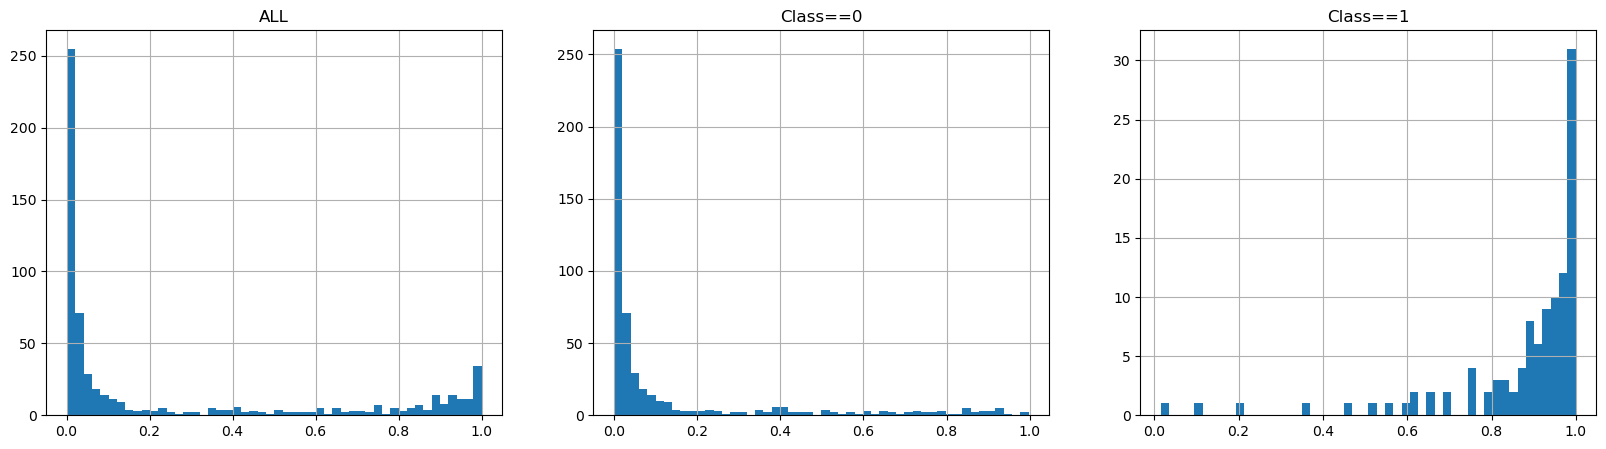

####################################################################################################
CV repeat nbr: 9 - metric: 0.2619


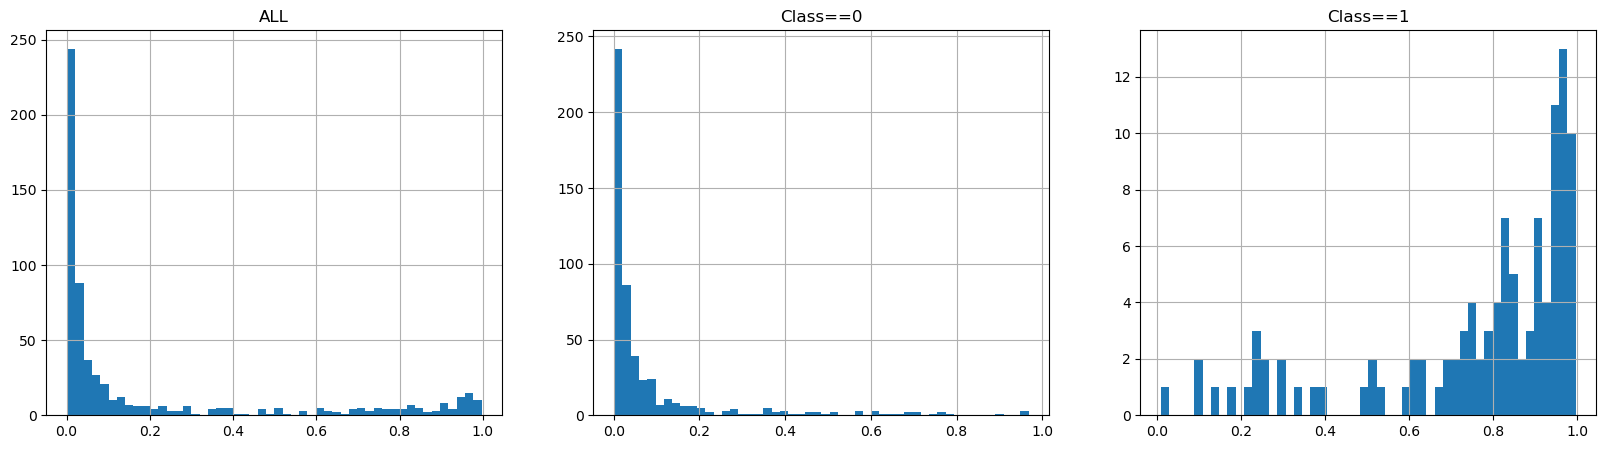

CV repeat nbr: 9 - metric: 0.2168


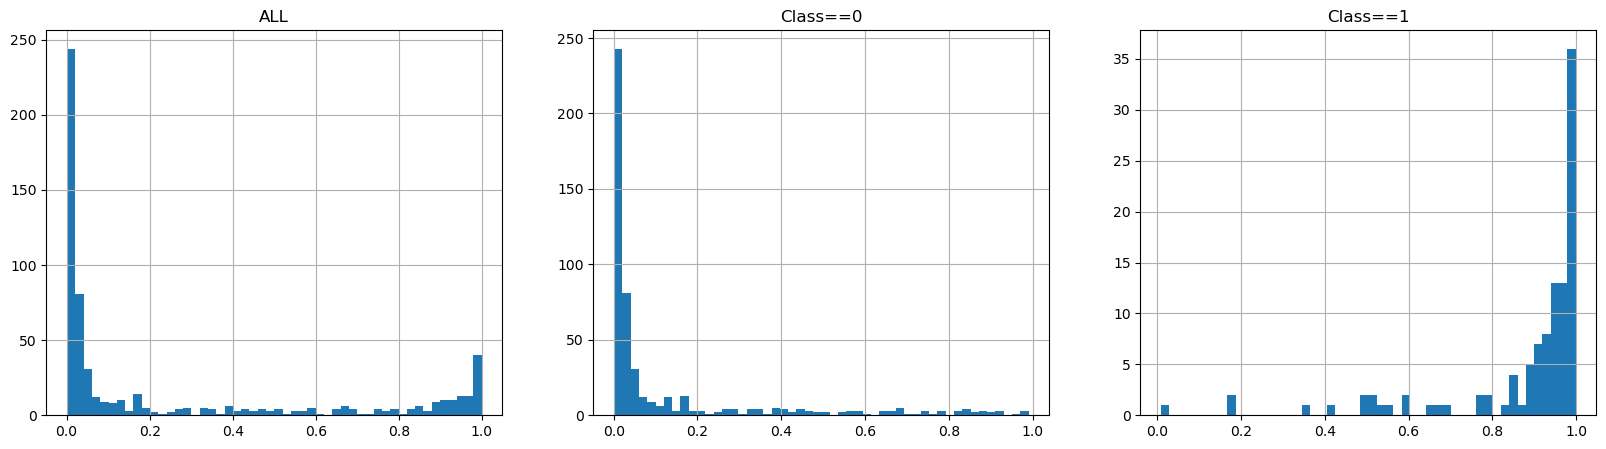

####################################################################################################
CV repeat nbr: 10 - metric: 0.2956


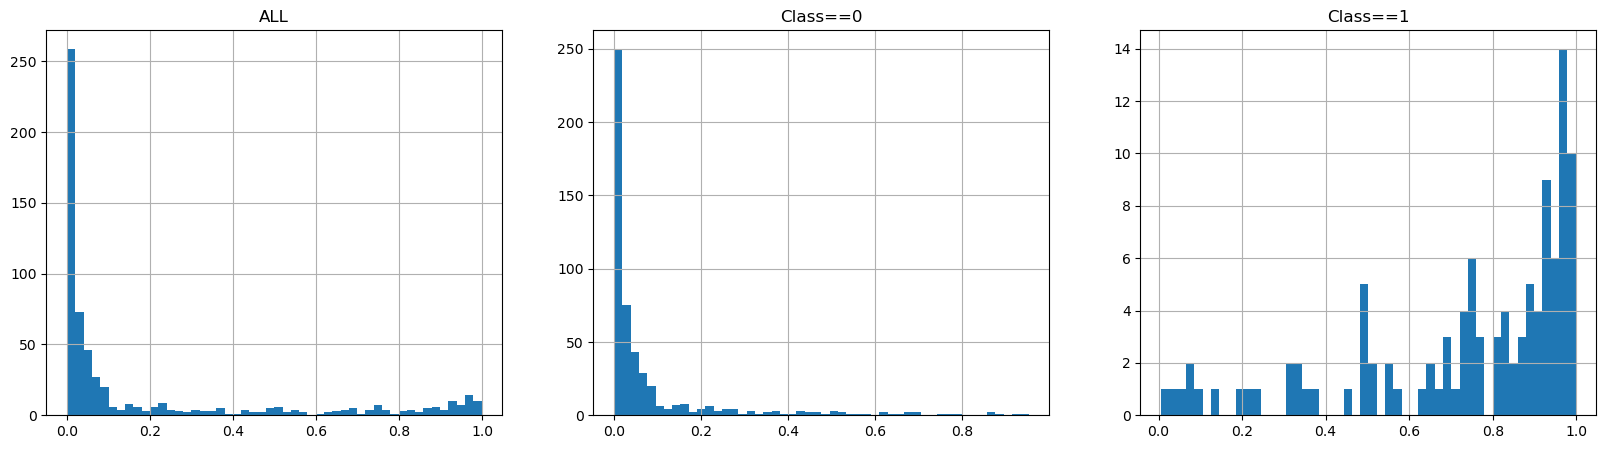

CV repeat nbr: 10 - metric: 0.2510


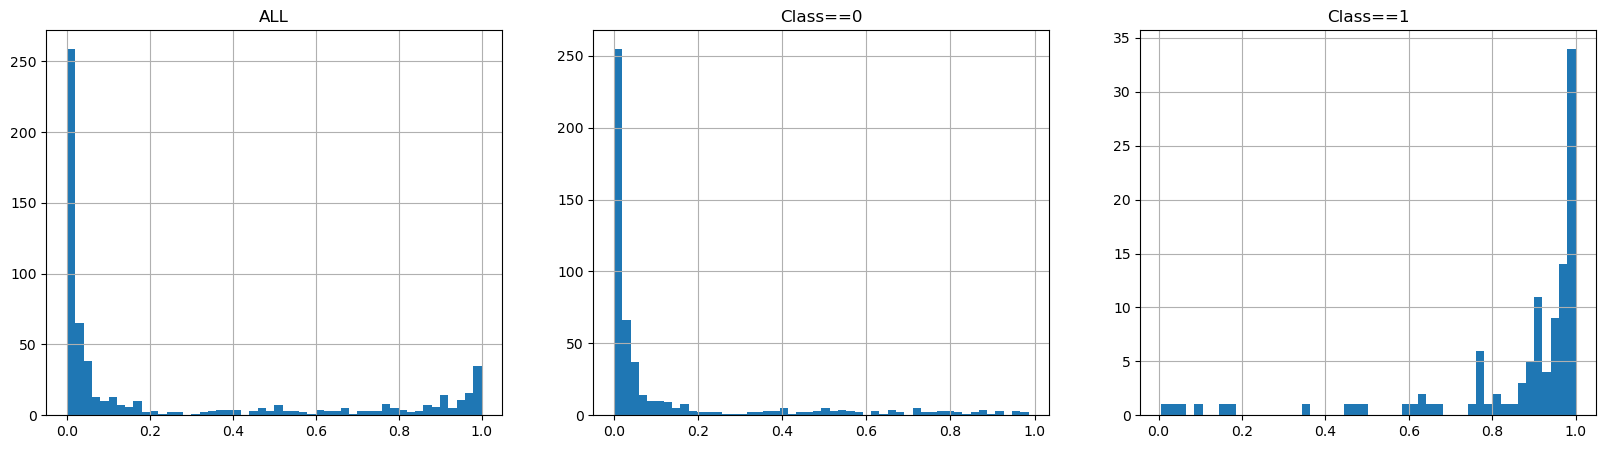

In [11]:
for i,oof in enumerate(oof_dfs):
    print("#"*100)
    oof = oof.copy(deep=True)
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()
    
    calib_p1 = calibrate_probs(
        oof.pred_proba.values,
        **calib_params
    )
    oof["pred_proba"] = calib_p1
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()

***
# inference

In [12]:
predicted_probs = [
    model.predict(xgb.DMatrix(test[input_cols]))
    for model in models
]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.46433604, 0.46433604, 0.46433604, 0.46433604, 0.46433604],
      dtype=float32)

In [13]:
predicted_probs = calibrate_probs(predicted_probs, **calib_params)
predicted_probs = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)
predicted_probs

array([0.7486216, 0.7486216, 0.7486216, 0.7486216, 0.7486216],
      dtype=float32)

In [14]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.to_csv("submission.csv", index=False)
sub.describe()

,class_0,class_1
count,5.000000,5.000000
mean,0.251378,0.748622
std,0.000000,0.000000
min,0.251378,0.748622
25%,0.251378,0.748622
50%,0.251378,0.748622
75%,0.251378,0.748622
max,0.251378,0.748622


***
## save artifacts


In [15]:
joblib.dump(models, "models.pkl")
joblib.dump(oof_dfs, "oof_dataframes.pkl")
oof_scores.to_csv("oof_scores.csv", index=False)
joblib.dump(calib_params, "calib_params.pkl")

['calib_params.pkl']

***